In [118]:
## Import 
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [119]:
import numpy as np
import pandas as pd

In [120]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [121]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import and_
from sqlalchemy import or_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, desc

In [122]:
# Create the engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [123]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [125]:
# We can view all of the classes that automap found
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [126]:
# reflect the tables
# Save references to each table
Measurement = Base.classes.measurement;
Station     = Base.classes.station; 

In [127]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [154]:
# Function to print keys - useful for development
def print_keys():
    print(Station.__dict__.keys())
    print(Measurement.__dict__.keys())

<div class="alert alert-block alert-info">
<b>Note:</b> 
Now ready to query the database
</div>

# Exploratory Climate Analysis

In [76]:
# Design a query to retrieve the last 12 months of precipitation 
# data and plot the results

# Get the last data point (max date) from the database
max_date = session.query(func.max(Measurement.date)).first()

In [77]:
# convert the string max_date to DATE type, save as a variable last_date
last_date = dt.datetime.strptime(max_date[0], '%Y-%m-%d')
#print(last_date)

In [78]:
# Calculate the date 1 year ago from the last data point in the database
# using timedelta(days = 365)
one_year_before = last_date - timedelta(days=365)

In [79]:
# Convert the DATE types back to strings
last_date_str       = last_date.strftime("%Y-%m-%d")
one_year_before_str = one_year_before.strftime("%Y-%m-%d")

<div class="alert alert-block alert-info">
<b>Note:</b> 
Dates now in correct format to proceed with query the database
</div>

### Design a query to retrieve the last 12 months of precipitation data and plot the results


In [80]:
# Load the results into a pandas dataframe. 
# Save the query results as a Pandas DataFrame and set the index to the date column

results = session.query(Measurement.station, Measurement.prcp, Measurement.date)\
                .filter(and_(Measurement.date >= one_year_before_str, \
                             Measurement.date <= last_date_str))

### Verifying query results
# for r in results:
#   print (r)

In [81]:
df = pd.DataFrame(results[:], columns=['Station', 'Prcp', 'Date'])

### Convert the date column to a Date Type for ease of computation
df['Date'] = pd.to_datetime(df['Date'])

### Set the index to the Date column
df.set_index('Date', inplace=True, )

# Verify the contents of the dataframe
#df.head(100)
#df.shape

In [132]:
# Sort the dataframe by date
df = df.sort_index(ascending=False)
df.head(3)
df.sort_values(['Prcp'], ascending=False)

,Station,Prcp
Date,,
2016-09-14,USC00516128,6.70
2017-04-29,USC00519523,6.25
2017-02-11,USC00519523,5.04
2017-07-22,USC00516128,4.00
2016-10-04,USC00516128,3.46
...,...,...
2016-08-31,USC00514830,NaN
2016-08-29,USC00517948,NaN
2016-08-27,USC00516128,NaN


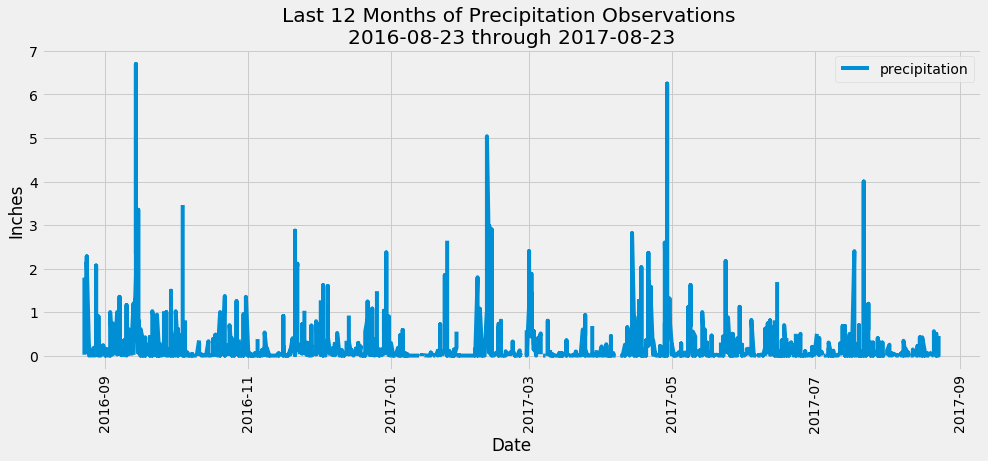

In [173]:
# Plot the precipitation data
x_values = df.index
y_values = df['Prcp']

# create axes
ax = plt.gca()
# plot values
plt.plot(x_values, y_values, label = "precipitation")
# label and format axes, add title and legend
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title ( f'Last 12 Months of Precipitation Observations \n{one_year_before_str} through {last_date_str}')
plt.legend(loc='upper right')
plt.xticks(rotation=90)


fig= plt.gcf()
fig.set_size_inches(15, 5.5)     # set a suitable size
#plt.subplots_adjust(right=0.75) 

plt.show()

fig.savefig("./Images/prcp.png")

<div class="alert alert-block alert-info">
<b>Observation:</b> 
There is usually less than 3 inches of precipitation for any give observation. However, 
there are three clear spikes in precipitation in February, April and September with recorded levels of 5-7 inches (see table below).  Interestingly, two of the three spikes were recorded at the same weather station. 

<table>
  <tr>
    <th>Date</th>
    <th>Station</th>
    <th>Prcp (Inches)</th>
  </tr>
  <tr>
    <td>2016-09-14</td>
    <td>USC00516128</td>
    <td>6.70</td>
  </tr>
  <tr>
    <td>2017-04-29</td>
    <td>USC00519523</td>
    <td>6.25</td>
  </tr>
  <tr>
    <td>2017-02-11</td>
    <td>USC00519523</td>
    <td>5.04</td>
  </tr>    
</table>
</div>

In [84]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


<div class="alert alert-block alert-info">
<b>Observation:</b> 
For over 2000 observations during the given year there appears to be very few very heavy precipitation dates.  On average for the year observed here precipitation is less than one-fifth of an inch, in Hawaii, apart from the spikes in three months of the year (as described above). 
</div>

In [85]:
# Design a query to show how many stations are available in this dataset?
#print(Station.__dict__.keys())

num_stations = session.query(func.count(Station.station)).first()
print(f"There are {num_stations[0]} stations available in this dataset ")

There are 9 stations available in this dataset 


In [86]:
## or we could count them like this
number_of_stations = session.query(func.count(distinct(Measurement.station))).first()
print(f"There are {number_of_stations[0]} stations available in this dataset")

There are 9 stations available in this dataset


<div class="alert alert-block alert-info">
<b>Note:</b> 
Nine stations can record over 2000 observations each year. 
</div>

In [87]:
# results = session.query(Station.id, Station.station, Station.name).\
#     order_by(Station.id.desc()).all()

# for r in results:
#   print(r)

In [141]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active_stations = session.query(Station.name, Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).order_by(desc(func.count(Measurement.station)))\
.filter(Measurement.station == Station.station)

# for station in most_active_stations:
#     print(station)
    
station_count_df = pd.DataFrame(most_active_stations[:], columns=['Station Name','Station', 'Station Count'])
station_count_df

,Station Name,Station,Station Count
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"WAIKIKI 717.2, HI US",USC00519397,2724
2,"KANEOHE 838.1, HI US",USC00513117,2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
6,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
7,"PEARL CITY, HI US",USC00517948,1372
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,511


<div class="alert alert-block alert-info">
<b>Observation:</b> 
Waihee 837.5, HI, US Station has the highest number (2772) of observations. 
</div>

#### Lowest, Highest and Average Temperture for Most Active Station



In [152]:
# Using the station id from the previous query, calculate 
# the lowest temperature recorded, 
# highest temperature recorded, and 
# the average temperature of the most active station?

# most active station is first row of dataframe containing station_count
station_id   = station_count_df.iloc[0]['Station']
station_name = station_count_df.iloc[0]['Station Name']
#print(station_id)

# Get the lowest temperature
low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_id).first()
#print(low_temp[0])

# Get the highest temperature
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_id).first()
#print(high_temp[0])
# Get the average temperature

ave_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_id).first()

print(f"For the most active station: \t\t{station_name}:\n" +
      f"The Station id \t\t\t\t{station_id}\n" +
      f"The lowest temperature recorded is \t{low_temp[0]} degrees\n" +
      f"The highest temperature recorded is \t{high_temp[0]} degrees\n" +
      f"The average temperature is \t\t{round(ave_temp[0],2)}")

For the most active station: 		WAIHEE 837.5, HI US:
The Station id 				USC00519281
The lowest temperature recorded is 	54.0 degrees
The highest temperature recorded is 	85.0 degrees
The average temperature is 		71.66


<div class="alert alert-block alert-info">
<b>Progress:</b> 
The most active station shows a moderate climate with temperatures ranging from 54 to 85.0 degrees, with and average of 71.66 degrees. 
</div>

In [90]:
# Design a query to retrieve the last 12 months of temperature observation data (TOBS).
# Filter by highest number of observations

In [91]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp_obs = session.query(Measurement.station, Measurement.tobs, func.count(Measurement.tobs))\
                    .group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs)))
# for h in highest_temp_obs:
#      print (h)
station_tobs = highest_temp_obs[0][0]
print(f"The station with the highest number of temperature observations is {station_tobs}")

The station with the highest number of temperature observations is USC00519281


In [93]:
# A query to retrieve the last 12 months of temperature observation data (TOBS).
results = session.query(Measurement.station, Measurement.prcp, Measurement.tobs, Measurement.date)\
                .filter(Measurement.station == station_tobs) \
                .filter(and_(Measurement.date >= one_year_before_str, Measurement.date <= last_date_str))

temperature_obs_df = pd.DataFrame(results[:], columns=['Station', 'Precipitation', 'Temperature', 'date'])

temperature_obs_df.head(3)

,Station,Precipitation,Temperature,date
0,USC00519281,1.79,77.0,2016-08-23
1,USC00519281,2.15,77.0,2016-08-24
2,USC00519281,0.06,80.0,2016-08-25


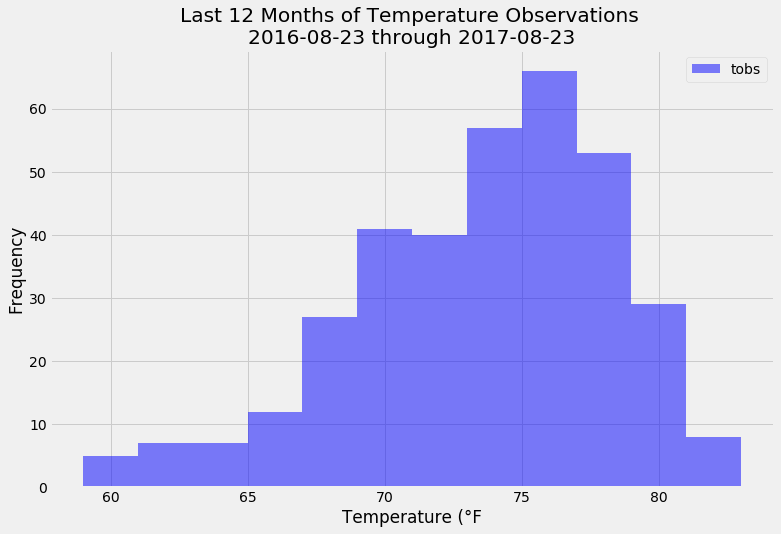

In [162]:
#Plot the results as a histogram with bins=12.

# set up the data
x    = temperature_obs_df['Temperature']
bins = 12

# plot the histogram
n, xbins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5,label='tobs' )

# Label and title the plot and axes
plt.xlabel(u'Temperature (\N{DEGREE SIGN}F')
plt.ylabel( 'Frequency')
plt.title (f'Last 12 Months of Temperature Observations \n{one_year_before_str} through {last_date_str}')
plt.legend()

fig= plt.gcf()
fig.set_size_inches(15, 7.5)     # set a suitable size
plt.subplots_adjust(right=0.75) 

plt.show()
fig.savefig("./Images/tobs_histogram.png")


<div class="alert alert-block alert-info">
<b>Observation:</b> 
The recorded temperature for the given dates is mostly between 75 and 77 degrees (F)
</div>

## Bonus Challenge Assignment

## Temperature Analysis I

-  Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
-  You may either use SQLAlchemy or pandas's read_csv() to perform this portion.
-  
-  Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [ ]:
#Identify the average temperature in June at all stations across all available years in the dataset. 

In [ ]:
#Identify the average temperature in June at all stations across all available years in the dataset. 

In [ ]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Will you use a paired t-test, or an unpaired t-test? Why?

## Temperature Analysis II

In [95]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [96]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = pd.to_datetime('2017-07-23')
trip_end_date   = pd.to_datetime('2017-08-08')

one_year_before_start = trip_start_date - timedelta(days=365)
one_year_before_end   = trip_end_date   - timedelta(days=365)

one_year_before_start = one_year_before_start.strftime("%Y-%m-%d")
one_year_before_end   = one_year_before_end.strftime("%Y-%m-%d")

#print(calc_temps(one_year_before_start, one_year_before_end))
prev_year = calc_temps(one_year_before_start, one_year_before_end)
tmin = prev_year[0][0]
tavg = prev_year[0][1]
tmax = prev_year[0][2]

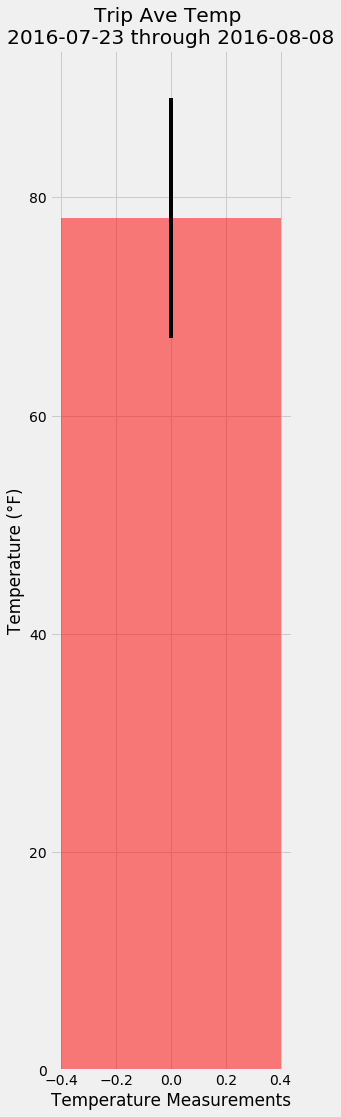

In [182]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

peak_to_peak = tmax - tmin

plt.bar(0, tavg, color = 'r', alpha = 0.5, align='center', yerr=peak_to_peak)

plt.xlabel( 'Temperature Measurements')
plt.ylabel(u'Temperature (\N{DEGREE SIGN}F)')
plt.title ( f'Trip Ave Temp \n{one_year_before_start} through {one_year_before_end}')

fig= plt.gcf()
fig.set_size_inches(5, 17.5)     # set a suitable size
plt.subplots_adjust(right=0.75) 

plt.show()

fig.savefig("./Images/tripave.png")

<div class="alert alert-block alert-info">
<b>Observation:</b> 
The average temperature looks perfect for the vacation
</div>

## Daily Rainfall Average

In [183]:
# This function called `calc_rainfall` will accept start date and end date in the format '%Y-%m-%d' 
# and return the total amount of rainfall for that range of dates
def calc_rainfall(start_date, end_date):
    """STATION, NAME, LATITUDE, LONGITUDE, ELEVATION, and PRECIPTIATION for a list of rainfall.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        STATION, NAME, LATITUDE, LONGITUDE, ELEVATION, and PRECIPTIATION 
    """
    
#     
    return session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
         func.sum(Measurement.prcp)).group_by(Station.name).filter(Station.station == Measurement.station)\
        .filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [184]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount a
# and list the station, name, latitude, longitude, and elevation


#print(calc_rainfall(one_year_before_start, one_year_before_end))
rain_results = calc_rainfall(one_year_before_start, one_year_before_end)

rainfall_df = pd.DataFrame(rain_results[:], columns=['Station', 'Name', 'Latitute',\
                                                     'Longitude', 'Elevation', 'Precipitation'])

#df.groupby('Station').sum()
rainfall_df

rainfall_df.sort_values(by=['Precipitation'], ascending=False)

,Station,Name,Latitute,Longitude,Elevation,Precipitation
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,17.55
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,16.19
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,11.98
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,5.36
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,4.98
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.10
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.19


In [100]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
#daily_normals("01-01")

In [101]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = pd.to_datetime('2017-07-23')
trip_end_date   = pd.to_datetime('2017-08-08')

# Use the start and end date to create a range of dates
range_of_dates = pd.date_range(start=trip_start_date, end=trip_end_date)
#range_of_dates


# Strip off the year and create a list of %m-%d strings
dates_list = []
for r in range_of_dates:
    #print(r.strftime("%m-%d"))
    dates_list.append(r.strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for day in dates_list:
    dn = daily_normals(day)
    normals.append([dn[0][0],dn[0][1], dn[0][2]])


In [102]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = pd.DataFrame(normals, columns = ['Min', 'Ave', 'Max'], index = dates_list)
trip_dates.head(3)

,Min,Ave,Max
07-23,70.0,76.203704,84.0
07-24,69.0,76.555556,81.0
07-25,67.0,76.890909,84.0


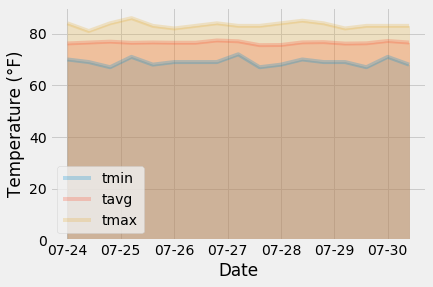

In [186]:
# Plot the daily normals as an area plot with `stacked=False`

ax = trip_dates.plot.area(stacked=False, alpha=0.25)

ax.set_xlabel("Date")
ax.set_ylabel(u'Temperature (\N{DEGREE SIGN}F)')
ax.set_xticklabels(trip_dates.index)
_ = ax.legend(['tmin', 'tavg', 'tmax'])


#plt.subplots_adjust(right=0.75) 


<div class="alert alert-block alert-info">
<b>Observation:</b> 
The temperature ranges look ideal for the duration of the vacation
</div>

# End of Notebook 